In [1]:
import os
import time
import numpy as np
import pandas as pd

import rasterio
import xarray as xr
import rioxarray as rioxr

import raster_to_features as rm

from shapely.geometry import Polygon

from joblib import load
import matplotlib.pyplot as plt

from scipy import stats
from scipy.ndimage import generic_filter

In [2]:
def classify_iceplant(raster, rfc):
    rm.raster_as_df(raster.to_numpy(), ['r','g','b','nir'])

    # find vegetation pixels to go into model
    # keep indices of water and low-ndvi pixels
    # adds ndvi and ndwi features for each pixel
    is_veg, water_index, not_veg_index = rm.add_spectral_features(df = rm.raster_as_df(raster.to_numpy(), 
                                                                                       ['r','g','b','nir']), #names of bands
                                                               ndwi_thresh = 0.3, 
                                                               ndvi_thresh = 0.05) 
    # select features
    is_veg.drop('ndwi', axis=1, inplace=True)
    is_veg = rm.add_date_features(is_veg, raster.datetime)
    # ---------------------------------------
    # predict using model

    preds = rfc.predict(is_veg.to_numpy())    
    t0 = time.time()
    print('finished predicting\n   time taken to predict: ', time.time() - t0,' s')

    # ---------------------------------------
    # recover pixel indices for iceplant classifications
    preds_df = pd.DataFrame(preds, 
                         columns=['is_iceplant'], 
                         index = is_veg.index)
    is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
    non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

    # ---------------------------------------
    # reconstruct indices into image
    indices = [non_iceplant_index,
               is_iceplant_index, 
               not_veg_index,
               water_index]
    values = [0,    # values assigned to pixels from each index
              1,
              3,    # *** CHANGED THIS TO HAVE  difference of +-2 in change detection ***
              3]
    t0 = time.time()
    reconstruct = rm.indices_to_image(raster.shape[1], raster.shape[2], indices, values, back_value=100)
    print('reconstructed image\n   time taken to reconstruct: ', time.time() - t0,' s')
    
    return reconstruct

# ---------------------------------------
def save_raster(filepath, raster, values):
    with rasterio.open(
        filepath,  # file path
        'w',           # w = write
        driver = 'GTiff', # format
        height = values.shape[0], 
        width = values.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = raster.rio.crs,
        transform = raster.rio.transform(),
    ) as dst:
        dst.write(values.astype(rasterio.uint8), 1)
    return 

# ---------------------------------------
# https://stackoverflow.com/questions/54439298/image-filter-which-uses-the-highest-occurence-of-pixel-values
# Modal filter
def modal(P):
    """We receive P[0]..P[8] with the pixels in the 3x3 surrounding window"""
    mode = stats.mode(P)
    return mode.mode[0]

In [3]:
# open pre-trained random forest classifier
rfc = load('spectral_rfc.joblib') 
print('loaded model')

loaded model


In [4]:
# campus lagoon box
reduce_box = Polygon([[-119.8458758654,34.404765813],
                      [-119.8436054232,34.404765813],
                      [-119.8436054232,34.406228424],
                      [-119.8458758654,34.406228424],
                      [-119.8458758654,34.404765813]])

itemid_20 = 'ca_m_3411934_sw_11_060_20200521'
itemid_12 = 'ca_m_3411934_sw_11_1_20120505_20120730'

fn_20 = 'box_2020_campus.tif'
fn_12 = 'box_2012_campus.tif'

# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
# reduce_box = Polygon([[-120.4629726682,34.4571320535],  # dgr aoi
#                       [-120.4584485416,34.4571320535],
#                       [-120.4584485416,34.4592144415],
#                       [-120.4629726682,34.4592144415],
#                       [-120.4629726682,34.4571320535]])

# itemid_20 = 'ca_m_3412037_nw_10_060_20200607'  # dgr 2020
# itemid_12 = 'ca_m_3412037_nw_10_1_20120518_20120730' # dgr 2012

# fn_20 = 'box_2020_dangermond.tif'
# fn_12 = 'box_2012_dangermond.tif'

In [5]:
#itemid = 'ca_m_3412037_nw_10_1_20120518_20120730' # dgr 2012
r_20 = rm.rioxr_from_itemid(itemid_20, 
                    reduce_box,
                    "EPSG:4326")
r_20

<xarray.DataArray (band: 4, y: 281, x: 357)>
[401268 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.384e+05 2.384e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0
    datetime:                  2020-05-21 00:00:00+00:00

In [6]:
rgb_20 = r_20.loc[1:3]
rgb_20

<xarray.DataArray (band: 3, y: 281, x: 357)>
[300951 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.384e+05 2.384e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0
    datetime:                  2020-05-21 00:00:00+00:00

In [10]:
rgb_20.shape

(3, 281, 357)

In [11]:
dtype = rasterio.dtypes.get_minimum_dtype(r_20)  # parameters for saving
fp = os.path.join(os.getcwd(),'temp','campus_point','campus_box_20.tif')

with rasterio.open(
    fp,  # file path
    'w',           # w = write
    driver = 'GTiff', # format
    height = rgb_20.shape[1], 
    width = rgb_20.shape[2],
    count = 3,  # number of raster bands in the dataset
    dtype = dtype,
    crs = rgb_20.rio.crs,
    transform = r_20.rio.transform(),
) as dst:
    dst.write(rgb_20.astype(dtype), [1,2,3])

In [12]:
r_12 = rm.rioxr_from_itemid(itemid_12, 
                    reduce_box,
                    "EPSG:4326")
r_12

<xarray.DataArray (band: 4, y: 169, x: 215)>
[145340 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.384e+05 2.384e+05 ... 2.386e+05 2.386e+05
  * y            (y) float64 3.811e+06 3.811e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    datetime:       2012-05-05 00:00:00+00:00

In [13]:
rgb_12 = r_12.loc[1:3]
dtype = rasterio.dtypes.get_minimum_dtype(rgb_12)  # parameters for saving
fp = os.path.join(os.getcwd(),'temp','campus_point','campus_box_12.tif')

with rasterio.open(
    fp,  # file path
    'w',           # w = write
    driver = 'GTiff', # format
    height = rgb_12.shape[1], 
    width = rgb_12.shape[2],
    count = 3,  # number of raster bands in the dataset
    dtype = dtype,
    crs = rgb_12.rio.crs,
    transform = rgb_12.rio.transform(),
) as dst:
    dst.write(rgb_12.astype(dtype), [1,2,3])

In [7]:
preds_20 = classify_iceplant(r_20,rfc)
#preds_12 = classify_iceplant(r_12,rfc)

finished predicting
   time taken to predict:  1.9073486328125e-06  s
reconstructed image
   time taken to reconstruct:  0.0032966136932373047  s


In [8]:
filter20 = generic_filter(preds_20, modal, (3, 3))
#filter12 = generic_filter(preds_12, modal, (3, 3))

/tmp/ipykernel_1996/2905194957.py:66: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(P)


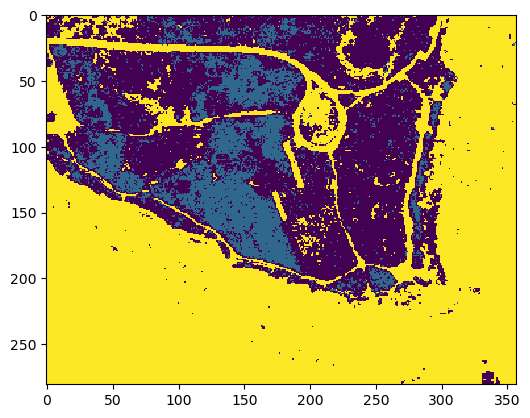

In [9]:
plt.imshow(preds_20, interpolation='none')
plt.show()

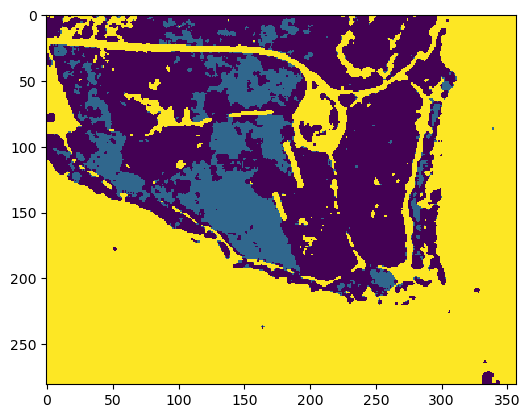

In [33]:
median_results = median_filter(preds_20, size=3)
plt.imshow(median_results, interpolation='none')
plt.show()

array([-2.,  0.,  1.])

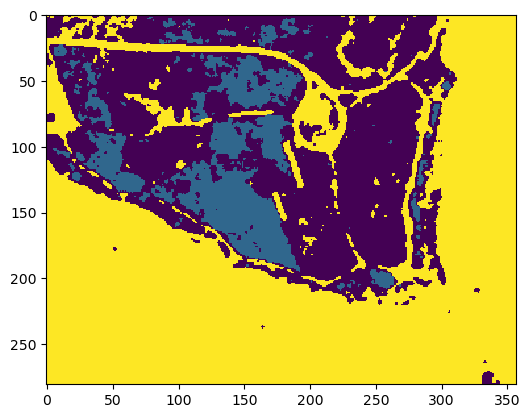

In [10]:
plt.imshow(filter20, interpolation='none')
plt.show()

In [32]:
from scipy.ndimage import maximum_filter, median_filter

In [ ]:
# plt.imshow(preds_12, interpolation='none')
# plt.show()

In [ ]:
# plt.imshow(filter12, interpolation='none')
# plt.show()

## Save and reopen as raster

In [13]:
fp = os.path.join(os.getcwd(),'temp','campus_point','campus_box_preds_12.tif')
save_raster(fp, r_12, preds_12)

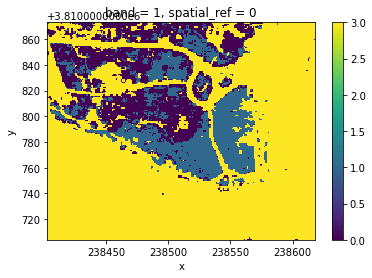

In [14]:
rast_preds_12 = rioxr.open_rasterio(fp).squeeze()
rast_preds_12.plot()

In [15]:
preds12_inter = rast_preds_12.rio.reproject_match(r_20, 
                                                  mehtod='nearest')

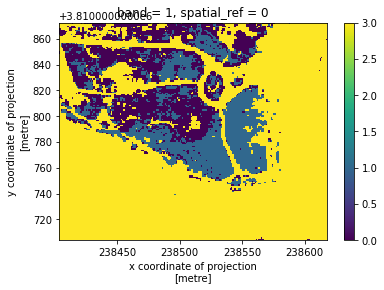

In [16]:
preds12_inter.plot()

In [17]:
filter12_inter = generic_filter(preds12_inter, modal, (3, 3))

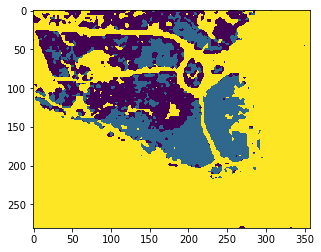

In [18]:
plt.imshow(filter12_inter, interpolation='none')
plt.show()

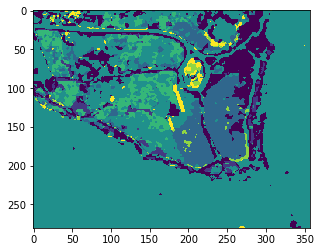

In [19]:
diff =  filter20 - filter12_inter
plt.imshow(diff, interpolation='none')
plt.show()

In [20]:
fp = os.path.join(os.getcwd(),'temp','campus_point','campus_box_preds_inter_filter_12.tif')
save_raster(fp, preds12_inter, filter12_inter)

fp = os.path.join(os.getcwd(),'temp','campus_point','campus_box_preds_filter_20.tif')
save_raster(fp, r_20, filter20)


In [18]:
dtype = rasterio.dtypes.get_minimum_dtype(diff)  # parameters for saving
dtype

'float32'

In [21]:
fp = os.path.join(os.getcwd(),'temp','campus_point','campus_box_preds_diff_20_12.tif')
with rasterio.open(
    fp,  # file path
    'w',           # w = write
    driver = 'GTiff', # format
    height = diff.shape[0], 
    width = diff.shape[1],
    count = 1,  # number of raster bands in the dataset
    dtype = rasterio.float32,
    crs = r_20.rio.crs,
    transform = r_20.rio.transform(),
) as dst:
    dst.write(diff.astype(rasterio.float32), 1)

In [29]:
test = np.arange(0,25).reshape(5,5)
test

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [31]:
generic = generic_filter(test, modal, (3, 3))
generic

/tmp/ipykernel_1996/2905194957.py:66: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(P)


array([[ 0,  0,  1,  2,  4],
       [ 0,  0,  1,  2,  4],
       [ 5,  5,  6,  7,  9],
       [10, 10, 11, 12, 14],
       [20, 20, 21, 22, 24]])